# Modeling - Positive/Negative Classifier

In [5]:
# Import the required libraries
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer

import string
import re
import wordcloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline 

from imblearn.over_sampling import RandomOverSampler
import imblearn.pipeline as imblearnpipeline

import pandas as pd
import numpy as np
from PIL import Image
from os import path
import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer

import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns


from myFunctions import process_tweet_text_encode_to_ascii
from myFunctions import get_social_media_stopwords_list
from myFunctions import plot_word_cloud
from myFunctions import clean_tweet, tokenize_tweet, tokenize_lemmatize_tweet
from myFunctions import show_peformance_metrics, plot_pretty_cf

np.random.seed(42)

In [6]:
# read in the processed data
all_tweets = pd.read_csv('../data/cleaned_tweets_all.csv')
print(all_tweets.shape)

(8698, 7)


## Text Processing 

In [7]:
# clean the tweets before performing TD-IDF vectorization
all_tweets['tweet_text'] = all_tweets['tweet_text'].apply(clean_tweet)
display(all_tweets['tweet_text'].head(5))


0    .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1    @jessedee Know about @fludapp ? Awesome iPad/i...
2    @swonderlin Can not wait for iPad 2 also. They...
3    @sxsw I hope this year's festival isn't as cra...
4    @sxtxstate great stuff on Fri SXSW: Marissa Ma...
Name: tweet_text, dtype: object

## Processing Done..let's get ready to build some Classification Models

In [8]:
##
# - Create TRAIN and TEST data sets from the Postive and Negative Tweet datasets.
# - Vectorize TRAIN with sklearn
# - Create a basic models
# - Fit each to our vectorized training data
# - Create predictions for TRAIN and TEST sets
# - Examine performance metrics for both TRAIN and TEST 
# - Experiment with model tuning AND/OR other model choices
# - The classes are imbalanced, use the weighted F1 score to analyze models' performance and choose winner.

In [9]:
corpus_binary = all_tweets[all_tweets['sentiment'] != 'Neutral']['tweet_text'].tolist()
labels_binary = all_tweets[all_tweets['sentiment'] != 'Neutral']['sentiment'].tolist()

X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(corpus_binary, labels_binary, test_size=0.2, random_state=42)

print(len(X_train_binary), len(y_train_binary), len(X_test_binary), len(y_test_binary))


2724 2724 681 681


In [10]:
# Text Processing - TF-IDF
# Use TF_IDF to focus on words that appear heavily in tweets from a given class, but rarely appear in tweets from other class/classes.

# Use tokenzer for tweets and the customized stopwords list
tfidvectorizer_for_binary = TfidfVectorizer(tokenizer=tokenize_lemmatize_tweet, 
                                        stop_words=get_social_media_stopwords_list(), 
                                        strip_accents='ascii',
                                        decode_error='ignore')

# Fit on TRAIN data
tf_idf_data_train_binary = tfidvectorizer_for_binary.fit_transform(X_train_binary)
# Creat a vectorized version of the TEST data
tf_idf_data_test_binary = tfidvectorizer_for_binary.transform(X_test_binary)

In [11]:
# TF-IDF - Let's check out the vocab for the ENTIRE corpus of Pos and Neg Tweets...Train and Test
print(len(tfidvectorizer_for_binary.vocabulary_.keys()))

4872


## Models!

In [13]:
nb_classifier_binary = Pipeline([  ('tfidf_vec', tfidvectorizer_for_binary),
                            ('clf', MultinomialNB()) ])

nb_classifier_binary.fit(X_train_binary, y_train_binary)

nb_classifier_binary_train_predictions = nb_classifier_binary.predict(X_train_binary)
nb_classifier_binary_test_predictions = nb_classifier_binary.predict(X_test_binary)


In [14]:
show_peformance_metrics(y_train_binary, 
                        nb_classifier_binary_train_predictions, 
                        X_train_binary, 
                        y_test_binary,
                        nb_classifier_binary_test_predictions, 
                        ['Negative', 'Positive'])

--------------------------------------------------------------------------
Training Accuracy: 0.8598 		 Testing Accuracy: 0.8678
--------------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       1.00      0.08      0.15        98
    Positive       0.87      1.00      0.93       583

    accuracy                           0.87       681
   macro avg       0.93      0.54      0.54       681
weighted avg       0.89      0.87      0.82       681

--------------------------------------------------------------------------


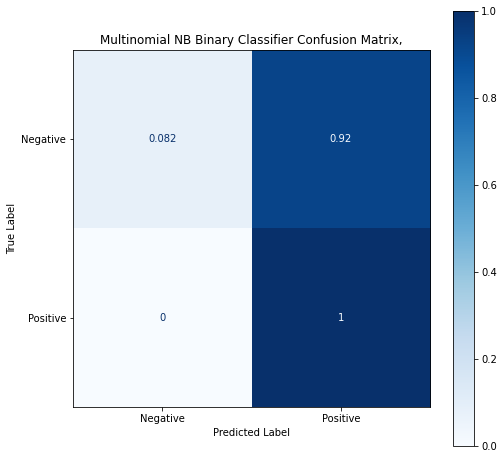

In [15]:
plot_pretty_cf(nb_classifier_binary, X_test_binary, y_test_binary, title='Multinomial NB Binary Classifier Confusion Matrix,')

In [16]:
# Try RandomForest
rf_clf_binary = Pipeline([ ('tfidf_vec', tfidvectorizer_for_binary),
                           ('clf', RandomForestClassifier(n_estimators=100) )])

rf_clf_binary.fit(X_train_binary, y_train_binary)

rf_clf_binary_train_predictions = rf_clf_binary.predict(X_train_binary)
rf_clf_binary_test_predictions = rf_clf_binary.predict(X_test_binary)


In [17]:
show_peformance_metrics(y_train_binary, 
                        rf_clf_binary_train_predictions, 
                        X_train_binary, 
                        y_test_binary,
                        rf_clf_binary_test_predictions, 
                        ['Negative', 'Positive'])

--------------------------------------------------------------------------
Training Accuracy: 0.9982 		 Testing Accuracy: 0.8884
--------------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.82      0.29      0.42        98
    Positive       0.89      0.99      0.94       583

    accuracy                           0.89       681
   macro avg       0.86      0.64      0.68       681
weighted avg       0.88      0.89      0.86       681

--------------------------------------------------------------------------


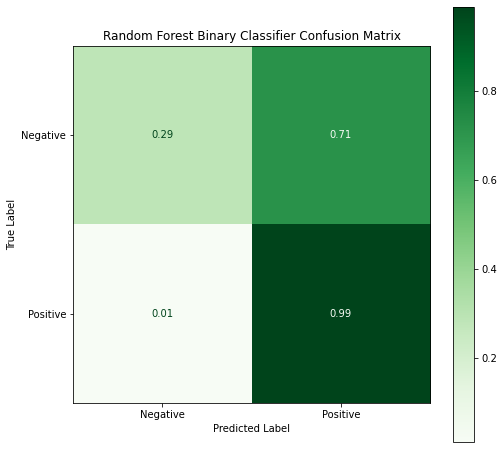

In [18]:
plot_pretty_cf(rf_clf_binary, X_test_binary, y_test_binary, cmap='Greens', title='Random Forest Binary Classifier Confusion Matrix')

In [19]:
# Try LinearSVC
svc_clf_binary = Pipeline([ ('tfidf_vec', tfidvectorizer_for_binary),
                            ('clf', LinearSVC()) ])

svc_clf_binary.fit(X_train_binary, y_train_binary)

svc_binary_train_predictions = svc_clf_binary.predict(X_train_binary)
svc_binary_test_predictions = svc_clf_binary.predict(X_test_binary)

In [20]:
show_peformance_metrics(y_train_binary, svc_binary_train_predictions, X_test_binary, y_test_binary, svc_binary_test_predictions, ['Negative', 'Positive'])

--------------------------------------------------------------------------
Training Accuracy: 0.993 		 Testing Accuracy: 0.8913
--------------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.69      0.44      0.54        98
    Positive       0.91      0.97      0.94       583

    accuracy                           0.89       681
   macro avg       0.80      0.70      0.74       681
weighted avg       0.88      0.89      0.88       681

--------------------------------------------------------------------------


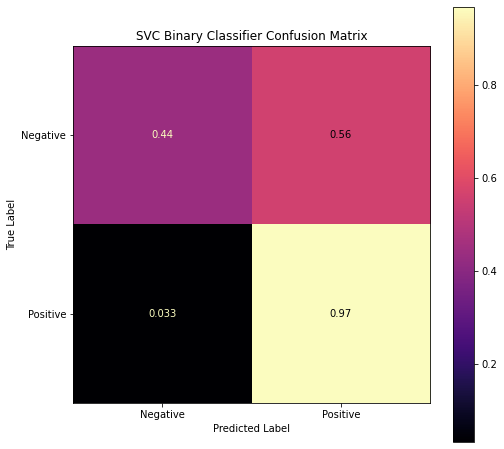

In [21]:
plot_pretty_cf(svc_clf_binary, X_test_binary, y_test_binary, cmap='magma', title='SVC Binary Classifier Confusion Matrix')

## Let's try to address the class imbalance. 

The corpus used to train this Binary classifier has two classes, Positive (84% of tweets) and Negative (16% of tweets). The Negative class is under-represented. 

A quick (and basic) way to address class imbalance is to *oversample the under-represented class*. 

"Random oversampling duplicates examples from the minority class in the training dataset and can result in overfitting for some models.  Random oversampling can be used for two-class (binary) classification problems and multi-class classification problems with one or more majority or minority classes.

Importantly, the change to the class distribution is only applied to the training dataset. The intent is to influence the fit of the models. The resampling is not applied to the test or holdout dataset used to evaluate the performance of a model."

 More details [here] (https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/) 


In [22]:
# Create an imblearn Pipeline to apply the RandomOverSampler to our minority classe Negative
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=7)

In [23]:
# imblearn Pipeline with MultinomialNB
nb_ros_binary_clf = imblearnpipeline.Pipeline([('tfidf_vec', tfidvectorizer_for_binary), 
                                        ('ros', oversampler),
                                        ('clf', MultinomialNB())])

nb_ros_binary_clf = nb_ros_binary_clf.fit(X_train_binary, y_train_binary)

nb_ros_binary_y_pred = nb_ros_binary_clf.predict(X_test_binary)
nb_ros_binary_y_pred_train = nb_ros_binary_clf.predict(X_train_binary)

In [24]:
show_peformance_metrics(y_train_binary, nb_ros_binary_y_pred_train, X_test_binary, y_test_binary, nb_ros_binary_y_pred, ['Negative', 'Positive'])

--------------------------------------------------------------------------
Training Accuracy: 0.9479 		 Testing Accuracy: 0.8326
--------------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.45      0.71      0.55        98
    Positive       0.95      0.85      0.90       583

    accuracy                           0.83       681
   macro avg       0.70      0.78      0.72       681
weighted avg       0.88      0.83      0.85       681

--------------------------------------------------------------------------


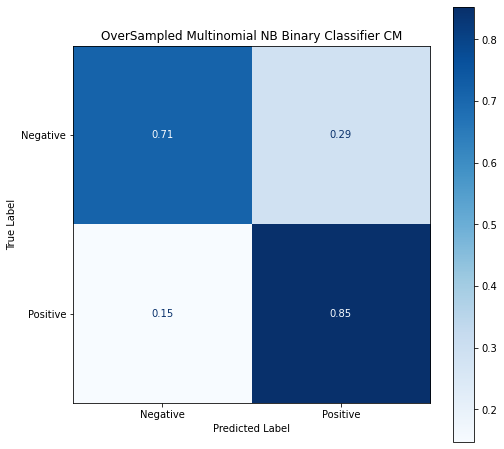

In [25]:
plot_pretty_cf(nb_ros_binary_clf, X_test_binary, y_test_binary, cmap='Blues', title='OverSampled Multinomial NB Binary Classifier CM')

In [26]:
# imblearn Pipeline with RandomForest
rf_ros_binary_clf = imblearnpipeline.Pipeline([('tfidf_vec', tfidvectorizer_for_binary), 
                                        ('ros', oversampler),
                                        ('clf', RandomForestClassifier(n_estimators=100) )])

rf_ros_binary_clf = rf_ros_binary_clf.fit(X_train_binary, y_train_binary)

rf_ros_binary_y_pred = rf_ros_binary_clf.predict(X_test_binary)
rf_ros_binary_y_pred_train = rf_ros_binary_clf.predict(X_train_binary)

In [27]:
show_peformance_metrics(y_train_binary, rf_ros_binary_y_pred_train, X_test_binary, y_test_binary, rf_ros_binary_y_pred, ['Negative', 'Positive'])

--------------------------------------------------------------------------
Training Accuracy: 0.9974 		 Testing Accuracy: 0.8899
--------------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.74      0.36      0.48        98
    Positive       0.90      0.98      0.94       583

    accuracy                           0.89       681
   macro avg       0.82      0.67      0.71       681
weighted avg       0.88      0.89      0.87       681

--------------------------------------------------------------------------


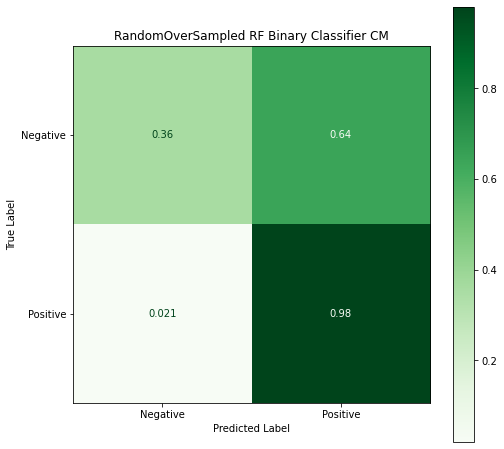

In [28]:
plot_pretty_cf(rf_ros_binary_clf, X_test_binary, y_test_binary, cmap='Greens', title='RandomOverSampled RF Binary Classifier CM')

In [29]:
# imblearn Pipeline with LinearSVC
svc_ros_binary_clf = imblearnpipeline.Pipeline([('tfidf_vec', tfidvectorizer_for_binary), 
                                        ('ros', oversampler),
                                        ('clf', LinearSVC() )])

svc_ros_binary_clf = svc_ros_binary_clf.fit(X_train_binary, y_train_binary)

svc_ros_y_pred = svc_ros_binary_clf.predict(X_test_binary)
svc_ros_y_pred_train = svc_ros_binary_clf.predict(X_train_binary)

In [30]:
show_peformance_metrics(y_train_binary, svc_ros_y_pred_train, X_test_binary, y_test_binary, svc_ros_y_pred, ['Negative', 'Positive'])

--------------------------------------------------------------------------
Training Accuracy: 0.9963 		 Testing Accuracy: 0.8634
--------------------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.53      0.51      0.52        98
    Positive       0.92      0.92      0.92       583

    accuracy                           0.86       681
   macro avg       0.72      0.72      0.72       681
weighted avg       0.86      0.86      0.86       681

--------------------------------------------------------------------------


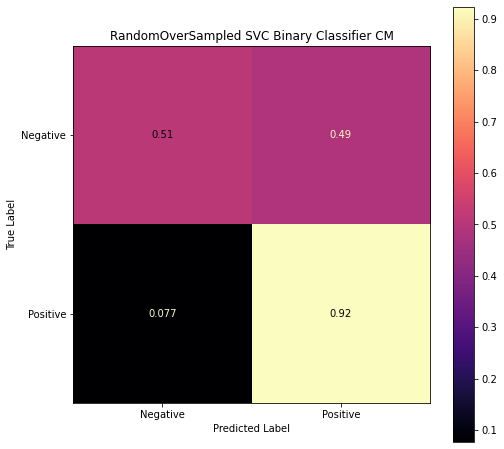

In [31]:
plot_pretty_cf(svc_ros_binary_clf, X_test_binary, y_test_binary, cmap='magma', title='RandomOverSampled SVC Binary Classifier CM')

## WINNER? TIE! 

### RandomForest with RandomOverSampling for Negative class 
### SVC

None of the binary classifiers did a good job with classifying Negative tweets, even with RandomOverSampling. RandomForest with RandomOverSampling and SVC had the highest weighted F1 scores of all models I trained. Both showed overfitting to a similar degree.

Here's the summary:
* MODEL -  Weighted F1 Score
* RandomForest ROS - 0.88  - Training Accuracy: 0.9974, Testing Accuracy: 0.8899
* SVC ROS - 0.86
* Multimonial NB ROS - 0.85
* RandomForest - 0.86
* SVC - 0.88 - Training Accuracy: 0.993, Testing Accuracy: 0.8913
* Multimonial NB  - 0.82

## Explore Model Feature Importance
 Let's pop the hood on models using [Lime] (https://github.com/marcotcr/lime)  NOTE: Lime did not work with the SVC model. (TODO: Do more research on why)

In [32]:
# Try out Lime for insights into our classifier!
explainer = LimeTextExplainer(class_names=['Negative', 'Positive'])

def ask_lime_to_explain(lime_explainer, tweet, classifer, features_num, show_text=True):
    exp = lime_explainer.explain_instance(tweet, classifer.predict_proba, num_features=features_num)
    display(exp.as_list())
    fig = exp.as_pyplot_figure()
    plt.show()
    exp.show_in_notebook(text=show_text)


In [33]:
# mimic the text processing the TfidfVectorizer does before vectorization
def apply_tokenize_lemmatize_stopwordstrip(tweet):
    tokens = tokenize_lemmatize_tweet(tweet)
    prepped_tweet = ' '.join([token for token in tokens if token not in get_social_media_stopwords_list()])
    return prepped_tweet

random_train_tweet = apply_tokenize_lemmatize_stopwordstrip(X_train_binary[777]) 
random_test_tweet = apply_tokenize_lemmatize_stopwordstrip(X_test_binary[77])

print(X_train_binary[777], y_train_binary[777])
print(random_train_tweet)
print(X_test_binary[77], y_test_binary[77])
print(random_test_tweet)

Grouped{in} nice app for groups, aber leider nur f�_r iPhone.  {link} sxsw Positive
grouped nice app group aber leider nur f � _r iphone
shoot, my ipad will not display any search results :( will have to go through questions later osmpw sxsw Negative
shoot ipad display search result :( go question later osmpw


[('app', 0.2816215486108374),
 ('nice', 0.15039812175968545),
 ('grouped', -0.032931848406551806),
 ('leider', -0.0327956950474044),
 ('aber', -0.030891128839134935),
 ('iphone', -0.025000391212695487),
 ('nur', -0.023274311092537095)]

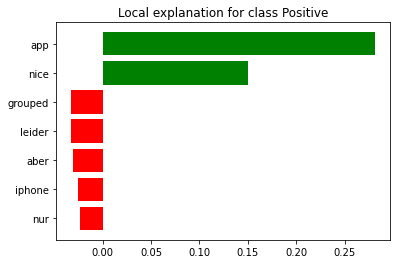

In [34]:
ask_lime_to_explain(explainer, random_train_tweet, rf_ros_binary_clf, 7)

[('ipad', 0.03330732331478306),
 ('result', -0.027394516258133227),
 ('search', -0.005761873754705779),
 ('go', -0.0041913981655392315),
 ('shoot', 0.0036434356097062508),
 ('later', 0.0025486318931642075),
 ('question', 0.0022817161418288113)]

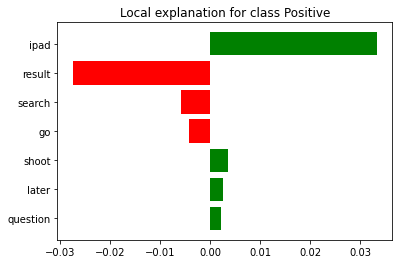

In [35]:
ask_lime_to_explain(explainer, random_test_tweet, rf_clf_binary, 7)

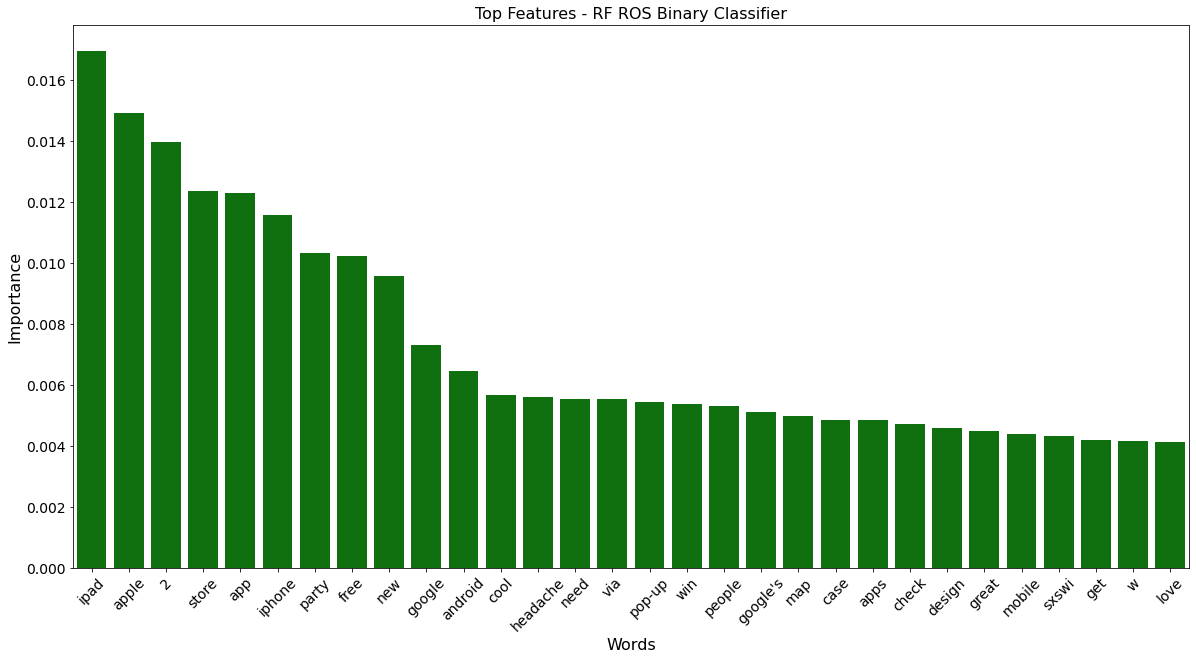

In [36]:

rf_ros_binary_feature_importances = dict(pd.Series(rf_ros_binary_clf['clf'].feature_importances_, 
                            index=tfidvectorizer_for_binary.get_feature_names()).sort_values(ascending=False)[:30])

fig = plt.subplots(figsize=(20, 10))
sns.barplot(x=list(rf_ros_binary_feature_importances.keys()), y=list(rf_ros_binary_feature_importances.values()), color='green')
plt.title('Top Features - RF ROS Binary Classifier', size=16)
plt.xlabel('Words', size=16)
plt.xticks(rotation=45, size=14)
plt.ylabel('Importance', size=16)
plt.yticks(size=14)
plt.show()

NOTE: SVC has no feature_importance TODO: reserach why

# Future Work:
* Try using SMOTE to address class imblance and see if it results in similar increases in overfitting as RandomOverSampling
* Hyperparameter tuning